First we import libraries and set the random seed:

In [0]:
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm.autonotebook import tqdm
from textwrap import wrap
import random
import sys
import io
import random
import numpy as np
import torch

torch.manual_seed(0)

The following block defines a dataset object which parses our data file and performs numericalisation of the sequence data:

In [0]:
class CodeDataset(Dataset):
    def __init__(self):
        download_url('https://github.com/ecs-vlc/COMP6248/raw/master/exercises/lab7/dataset.txt', '.', 'dataset.txt', None)
        with io.open('dataset.txt', 'r') as f:
            self.data = f.readlines()

        self.PAD='_'
        self.SOS='^'
        self.EOS='$'
        self.PAD_IDX=0

        # construct the vocabularies to numericalise the data
        self.alphabet = "*".join(self.PAD+self.SOS+self.EOS+"abcdefghijklmnopqrstuvwxyz ").split('*')

        self.alphabet_indices = dict((c, i) for i, c in enumerate(self.alphabet))
        self.indices_alphabet = dict((i, c) for i, c in enumerate(self.alphabet))

        self.morsebet = self.PAD+self.SOS+self.EOS+'.- /'
        self.morse_indices = dict((c, i) for i, c in enumerate(self.morsebet))
        self.indices_morse = dict((i, c) for i, c in enumerate(self.morsebet))

    def encode_alpha(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.alphabet_indices[char]

        return x

    def decode_alpha(self, ten, skip_tok=False):
        s = ''
        ten = ten.view(-1)
        for v in ten.view(-1):
            if not skip_tok:
                s += self.indices_alphabet[v.item()]
            elif v>2:
                s += self.indices_alphabet[v.item()]
        return s

    def encode_morse(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.morse_indices[char]

        return x

    def decode_morse(self, ten):
        s = ''
        for v in ten:
          s += self.indices_morse[v]
        return s

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        inp, out = self.data[i].strip().split('|')
        x = self.encode_morse(inp)
        y = self.encode_alpha(out[::-1])
        return x, y


# This will be used to automatically pad all batch items to the same length
def pad_collate(batch): 
    data = [item[0] for item in batch]
    data = pad_sequence(data)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets)
    return [data, targets]

# Load the data and split randomly into training and val subsets
ds = CodeDataset()
tr, va = random_split(ds, [len(ds) - len(ds)//3, len(ds)//3])
trainloader = DataLoader(tr, batch_size=1024, shuffle=True, collate_fn=pad_collate)
valloader = DataLoader(va, batch_size=1024, shuffle=False, collate_fn=pad_collate)

Using downloaded and verified file: ./dataset.txt


In [0]:
tr.dataset.data

['^ .--. .-. . ..-. .- $|^prefa$\n',
 '^ .-. . $|^re$\n',
 '^ . $|^e$\n',
 '^ ..-. .- $|^fa$\n',
 '^ .- -.-. . / ... ..- $|^ace su$\n',
 '^ -.-. . $|^ce$\n',
 '^ . $|^e$\n',
 '^ / ... ..- .--. .--. --- $|^ suppo$\n',
 '^ ... ..- .--. $|^sup$\n',
 '^ ..- .--. $|^up$\n',
 '^ .--. .--. --- ... .. -. $|^pposin$\n',
 '^ .--. --- ... .. $|^posi$\n',
 '^ --- ... .. -. --. $|^osing$\n',
 '^ ... .. -. --. / - $|^sing t$\n',
 '^ .. -. --. $|^ing$\n',
 '^ -. --. / $|^ng $\n',
 '^ --. / - $|^g t$\n',
 '^ / - .... .- - $|^ that$\n',
 '^ - .... .- - $|^that$\n',
 '^ .... .- - / - $|^hat t$\n',
 '^ .- - / - .-. $|^at tr$\n',
 '^ - $|^t$\n',
 '^ / - .-. ..- - .... $|^ truth$\n',
 '^ - .-. ..- - $|^trut$\n',
 '^ .-. ..- - .... / .. $|^ruth i$\n',
 '^ ..- - $|^ut$\n',
 '^ - .... / .. ... / $|^th is $\n',
 '^ .... / .. $|^h i$\n',
 '^ / .. ... / $|^ is $\n',
 '^ .. ... / .- / .-- $|^is a w$\n',
 '^ ... $|^s$\n',
 '^ / $|^ $\n',
 '^ .- / .-- --- -- .- $|^a woma$\n',
 '^ / .-- --- -- .- $|^ woma$\n',
 '^ .

We next define the model architecture, which is made up of an encoder, a decoder and the Seq2Seq class which ties everything together:

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        
    def forward(self, src):
        # TODO
        #All the encoder needs to do is pass the input through the embedding and then intothe LSTM. 
        #The forward method should return the hidden state and the cell state of the LSTM as itsoutput.  
        #The output of the LSTM should be ignored as it’s not used in this model.
        embedded = self.embedding(src)
        output, (hidden, cell) = self.rnn(embedded)
        return (hidden, cell)
        

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))        
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module): #输入一段摩斯电码里chunk转成的代号  [3][4][6]... ，输出预测的英文代号   [20]
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg=None, teacher_forcing_ratio = 0.5, maxlen=5, padding_idx=0):
        batch_size = src.shape[1] #1   batch:7*1
        trg_len = trg.shape[0] if trg is not None else maxlen #输出密码长度
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(src.device) #概率分布
        hidden, cell = self.encoder(src)

        input = torch.ones(batch_size, dtype=torch.long, device=src.device) * padding_idx #[0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force and trg is not None else top1
        
        return outputs


INPUT_DIM = len(ds.morsebet)
OUTPUT_DIM = len(ds.alphabet)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
model = Seq2Seq(enc, dec).cuda()




In [0]:
try: 
    import torchbearer
except:
    !pip install torchbearer

from torchbearer.callbacks.decorators import on_end_training




In [0]:

Lplot = []
global Lplot

def Lplot(func):
  def wrap(pred, y):
    loss = func(pred, y)
    Lplot.append(loss)
    return loss
  return wrap

def wrap(pred, y, func):
  loss = func(pred, y)
  Lplot.append(loss)
  return loss


crit = nn.CrossEntropyLoss(ignore_index=ds.PAD_IDX)
#@Lplot
#crit = wrap(pred, y, crit)

Finally, we can train and evaluate the model:

In [0]:
#crit = nn.CrossEntropyLoss(ignore_index=ds.PAD_IDX)

opt = optim.Adam(model.parameters())

Lplot = []


  



for e in range(10):
    model.train()

    with tqdm(total=len(trainloader), desc='train') as t:
        epoch_loss = 0
        for i, (x, y) in enumerate(trainloader):
            x = x.cuda()
            y = y.cuda()

            opt.zero_grad()
            pred = model(x, y, padding_idx=ds.PAD_IDX)

            pred_dim = pred.shape[-1]
            pred = pred[1:].view(-1, pred_dim)
            y = y[1:].view(-1)
            
            #loss = crit(pred, y)

            loss = wrap(pred, y, crit)
            Lplot.append(loss)
            loss.backward()
            opt.step()
            
            epoch_loss = (epoch_loss*i + loss.item()) / (i+1)

            t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
            t.update()
    
    # model.eval()
    # with tqdm(total=len(valloader), desc='val') as t:
    #     with torch.no_grad():
    #         epoch_loss = 0
    #         for i, (x, y) in enumerate(valloader):
    #             x = x.cuda()
    #             y = y.cuda()

    #             pred = model(x, y, teacher_forcing_ratio=0, padding_idx=ds.PAD_IDX)

    #             pred_dim = pred.shape[-1]
    #             pred = pred[1:].view(-1, pred_dim)
    #             y = y[1:].view(-1)

    #             loss = crit(pred, y)
    #             epoch_loss = (epoch_loss*i + loss.item()) / (i+1)

    #             t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
    #             t.update()

In [0]:
def decode(code):
  out = ''
  for chunk in code.split(' '):#根据空格分隔code成语块
    num = ds.encode_morse('^ ' + chunk + ' $').unsqueeze(1) #encode a chunk into morse
    #print(num.shape) # 6*1
    #a series of indices of morse 一段摩斯电码 其中各个符号转成其对应的index
    pred = model(num.cuda(), maxlen = 2) #输出每个index是每个单词的代号的概率(1*30)，用argmax取得每个index的预测/推断标签
    pred = pred[1:].view(-1, pred_dim).argmax(-1)
    out += ds.decode_alpha(pred.cpu())[::-1] #代号转回单词
  return out



code1 = '.- -. ... .-- . .-. / - .... . / ..-. --- .-.. .-.. --- .-- .. -. --.'

code2 = '.-- .... -.-- / .. ... / - .... . / --- .-. -.. . .-. / --- ..-. / - .... . / --- ..- - .--. ..- - / .-. . ...- . .-. ... . -..'

code3 = '.-- .... .- - / .. ... / - .... . / .--. --- .. -. - / --- ..-. / - . .- -.-. .... . .-. / ..-. --- .-. -.-. .. -. --.'

decode(code3)

'what is the point of teacher forcing'

In [0]:
def decode2(code):
  out = ''
  for chunk in code.split(' '):#根据空格分隔code成语块
    num = ds.encode_morse('^ ' + chunk + ' $').unsqueeze(1) #encode a chunk into morse
    #num: a series of indices of morse 一段摩斯电码 其中各个符号转成其对应的index

    pred = model(num.cuda(), maxlen = 2) #输出的每个index是每个字母代号的概率(1*30)，用argmax取得每个index的预测/推断标签
    pred = pred[1:].view(-1, pred_dim).argmax(-1)
    out += ds.decode_alpha(pred.cpu())[::-1] #代号转回单词
  return out

decode2(".-- .... -.-- / .. ... / - .... . / --- .-. -.. . .-. /")

'why is the order '

In [0]:
#ds.decode_alpha(torch.tensor([3,4,5]))[::-1]
ds.decode_alpha(model(torch.tensor([[1],[5],[3],[5],[2],[1],[5],[4],[3],[3],[5],[2]]).cuda(), maxlen = 3)[1:].view(-1, pred_dim).argmax(-1).cpu())

'de'

In [0]:
np.array([1,2,3,4,5,6,7,8,0])[::3]

array([1, 4, 7])

Text(0, 0.5, 'Loss')

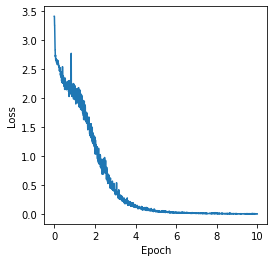

In [0]:
import matplotlib.pyplot as plt

for j in range(len(Lplot)):
  Lplot[j] = np.float(Lplot[j])





fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
ax.plot(np.arange(0, 10, 1/326), Lplot)
#ax.set_ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Loss')

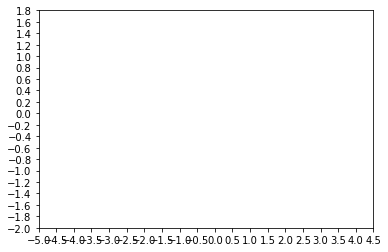

In [3]:
import matplotlib.pyplot as plt
import numpy as np
my_x_ticks = np.arange(-5, 5, 0.5)      #显示范围为-5至5，每0.5显示一刻度
my_y_ticks = np.arange(-2, 2, 0.2)      #显示范围为-2至2，每0.2显示一刻度
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
a=1